In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Set rangdom seed (while we are not using it, probably)
np.random.seed(1)

# The first two events are not with data
first_good_event=2

num_channels = 128

# Open file
events = uproot.open("003200_v9_hists.root")["events"]

# Uncomment to see file contents
# events.keys()

In [3]:
# Now we need to extract number of time-bins for each channel.
# The number is actually the same for the whole run, so we need to get only one element
# So we taking 1st element from 1st event we read (1st and the only event)
num_time_bins=events['srs_raw_samples_count'].array(library="np", entry_start=first_good_event, entry_stop=first_good_event+1)[0][0]
print(f"Number of time bins: {num_time_bins}")

Number of time bins: 6


In [4]:
type(events)

uproot.models.TTree.Model_TTree_v20

In [5]:
entry_start = 2
entry_stop = entry_start + 1000
# 'srs_raw_channel',
# 'srs_raw_apv_id',
# 'srs_raw_channel_apv',
# 'srs_raw_best_sample',
# 'srs_raw_samples_index',
# 'srs_raw_samples_count',

all_samples =  events['srs_raw_samples'].array(library="np", entry_start=entry_start, entry_stop=entry_stop)

num_apvs = int(len(all_samples[0])/num_time_bins/num_channels)
print(f"Number of APVs: {num_apvs}")


Number of APVs: 7


In [6]:
#apvs = events['srs_raw_channel'].array(library="np", entry_start=entry_start, entry_stop=entry_stop)


## Explanation of data: 
We have data in *srs_raw_samples* that looks like this (**num_time_bins=3**)
```
[
  [2820, 2810, 2717, 2774,  ...],  # event 0
  [2886, 2814, 2757, 2833,  ...],  # event 1
  ...
]
```
The values correspond to apv:channel:time-bin
Imagine we have 3 time bins, then the previous data for a single event (1 row) will correspond to

```
[apv0:ch0:t0, apv0:ch0:t1, apv0:ch0:t2, apv0:ch1:t0 ... apv0:ch128:t2, apv1:ch0:t0, ...]
```

Now we want to reshape this array so that time bins are a separate arrays of each channel
i.e. we had `[[1,2,3,4,5,6], ...]` we want `[[[1,2,3],[4,5,6]], ...]`
To do this we use `array.reshape((n_events, n_apvs*n_channels, n_time_bins))`

```python
expl_array = np.array([[1,2,3,4,5,6],[7,8,9,10,11,12]])
reshape_tuple = (len(expl_array), int(len(expl_array[0])/3), 3)
expl_array = expl_array.reshape(reshape_tuple)
```

That would give us: 

```
array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]])
```

In [7]:
reshape_tuple = (len(all_samples), num_apvs, num_channels, num_time_bins)
print(f"Reshaping {np.shape(np.vstack(all_samples))} to {reshape_tuple}")
channel_data = np.vstack(all_samples).reshape(reshape_tuple)
channel_data.shape

Reshaping (598, 5376) to (598, 7, 128, 6)


(598, 7, 128, 6)

In [8]:
# Compute the mean over the 0-th and 3-rd axes
pedestals = np.mean(channel_data, axis=(0, 3))
pedestals

array([[2803.72408027, 2880.99721293, 2891.51755853, 2909.65635452,
        2975.16164994, 2942.27257525, 2938.42725753, 2913.28901895,
        2943.86761427, 2938.46822742, 2912.7416388 , 2913.18952062,
        2947.51950948, 2940.63071349, 2921.55406912, 2911.63963211,
        2934.68060201, 2960.32664437, 2925.12792642, 2916.87848384,
        2969.6719621 , 2946.9793757 , 2912.71209588, 2897.99108138,
        2934.50083612, 2936.38154961, 2903.82971014, 2888.98634337,
        2934.39409142, 2902.59643255, 2914.11622074, 2893.90468227,
        2962.89437012, 2946.05156076, 2924.76393534, 2924.12040134,
        2974.49916388, 2933.43561873, 2929.37402453, 2903.94648829,
        2940.91443701, 2925.04821628, 2918.3977146 , 2892.98662207,
        2949.58221851, 2903.46599777, 2908.90607581, 2893.39827202,
        2953.02703456, 2953.12987737, 2910.6229097 , 2916.88043478,
        2952.75473802, 2944.7048495 , 2915.35479376, 2908.47101449,
        2957.68645485, 2922.68199554, 2904.09057

<BarContainer object of 128 artists>

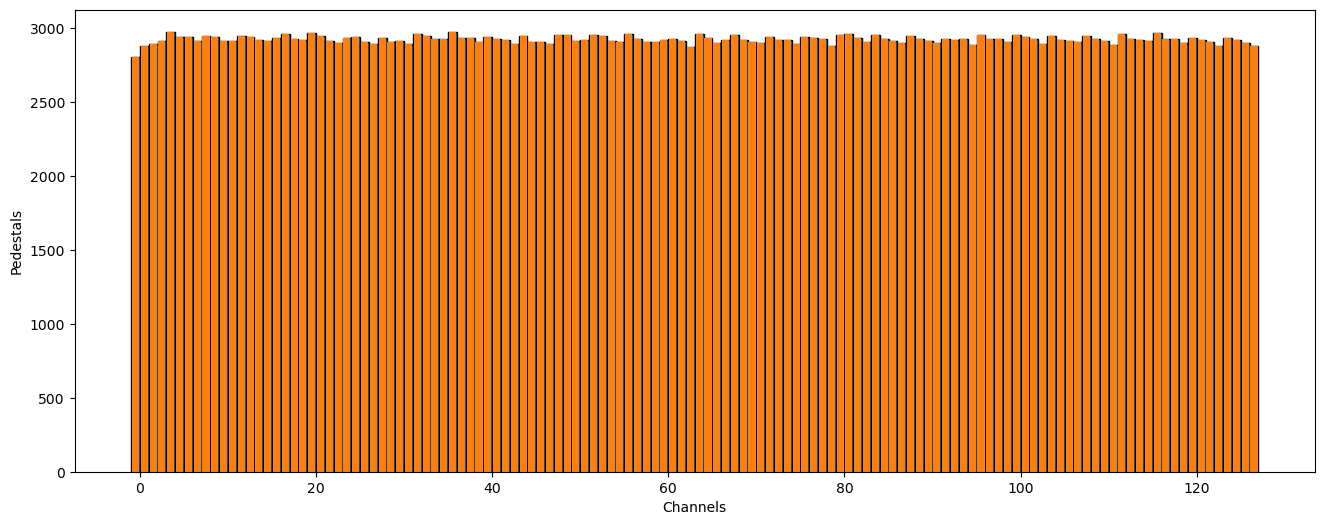

In [9]:
# Generate x values
x_values = np.arange(128) - 0.5

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(16, 6))  # You can specify your figure size here

# Create the bar plot on the axes object
ax.bar(x_values, pedestals[0], width=1.0, edgecolor='black')

# Set axis titles
ax.set_xlabel('Channels')
ax.set_ylabel('Pedestals')

plt.bar(np.arange(128) - 0.5, pedestals[0])#, where='post')

In [10]:

# Reshape mean_array for broadcasting
mean_array_reshaped = pedestals[:, :, np.newaxis]

# Subtract mean_array from every element in array across the 0-th and 3-rd axes
array_centered = -1*(channel_data - mean_array_reshaped)

# Verify the operation
array_centered.shape

(598, 7, 128, 6)

In [11]:
#np.transpose(array_centered, (0,1,3,2)).reshape(len(array_centered),num_apvs, num_channels*num_time_bins)
flattened = np.transpose(channel_data, (0,1,3,2)).reshape(len(array_centered),num_apvs, num_channels*num_time_bins)

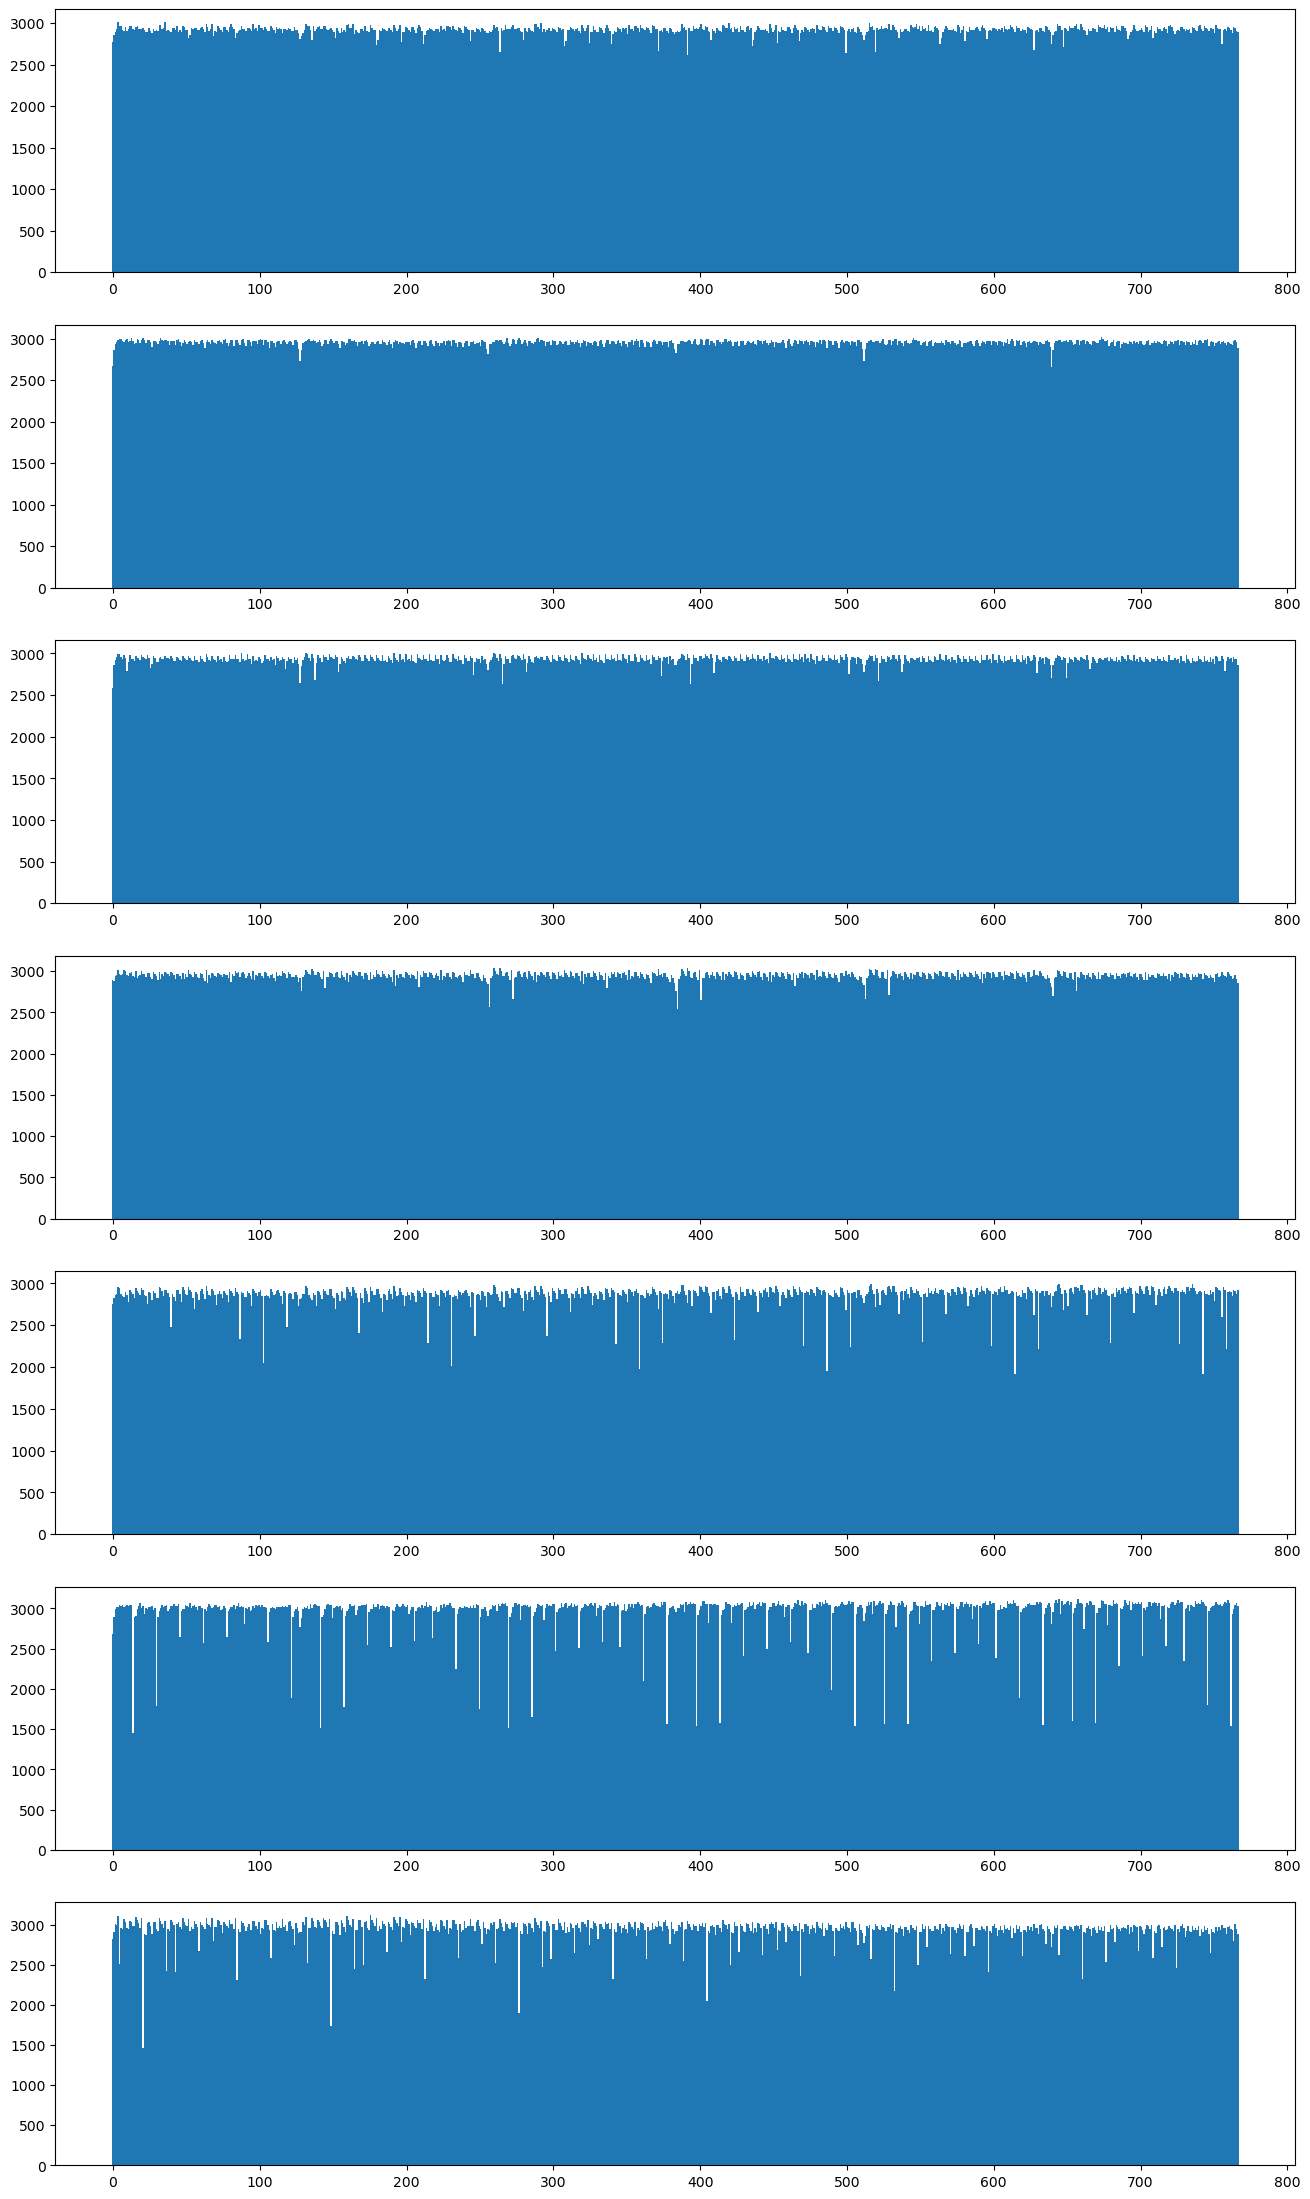

In [20]:
# Generate x values
x_values = np.arange(num_channels*num_time_bins) - 0.5

# Create the figure and axes objects
fig, axes = plt.subplots(num_apvs, 1, figsize=(16, 4*num_apvs))  # You can specify your figure size here
axes
for i,ax in enumerate(axes.flat):
    ax.bar(x_values, flattened[5][i], width=1)
    # Create the bar plot on the axes object
    #ax.bar(x_values, flattened[4][2], width=1)
    
    # Set axis titles
    #ax.set_xlabel('Channels')
    #ax.set_ylabel('Pedestals')

#plt.bar(np.arange(128) - 0.5, pedestals[0])#, where='post')

In [ ]:
entry_start = 2
entry_stop = 10
# 'srs_raw_channel',
# 'srs_raw_apv_id',
# 'srs_raw_channel_apv',
# 'srs_raw_best_sample',
# 'srs_raw_samples_index',
# 'srs_raw_samples_count',

all2 = events['srs_raw_samples'].array(entry_start=entry_start, entry_stop=entry_stop)

 

In [18]:
all2[0]

NameError: name 'all2' is not defined

In [19]:
# Creating a 3D array for demonstration
array = np.array([[[1, 2, 3], [4,5,6]], [[7,8, 9], [10,11,12]]])

# Transpose the array over the second and third axes
transposed_array = np.transpose(array, (0, 2, 1))

# Reshape each 2x2 sub-array into a 1D array
result_array = transposed_array.reshape(transposed_array.shape[0], -1)

result_array

array([[ 1,  4,  2,  5,  3,  6],
       [ 7, 10,  8, 11,  9, 12]])